In [4]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:80% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:22pt;}
div.text_cell_render.rendered_html{font-size:18pt;}
div.text_cell_render ul li{font-size:22pt; line-height:30px;}
div.output {font-size:22pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:22pt;}
div.prompt {min-width:40px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:22pt;padding:5px;}
table.dataframe{font-size:22px;}
</style>
"""))


- red wine 품질 등급 예측
```
1. 데이터셋 확보 & 전처리
독립변수와 타겟변수 분리 -> 독리비변수 스케일조정(StandardScaler)
-> 타겟변수원핫인코딩(get_dummies) -> 훈련셋과 테스트셋분리(train_test_split)
2. 모델 구성(입력11, 출력?)
3. 모델학습과정 설정(다중분류로 설정)
4. 모델 학습(callbacks 이용)
5. 모델평가 - 그래프, 평가(테스셋), 교차표/혼동행렬
6. 모델 저장/ 사용
```

In [18]:
import numpy as np
import pandas as pd # read_csv, get_dummies, crosstab
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras import metrics # compile
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt


In [19]:
# 데이터 읽어오기
# np.loadtxt('data/winequality-red.csv', delimiter=';', skiprows=1)
# np.genfromtxt('data/winequality-red.csv', delimiter=';', skip_header=1)
redwine = pd.read_csv('./data/winequality-red.csv', sep=';')
redwine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [20]:
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [21]:
# 타겟변수의 균형
redwine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [22]:
# 독립변수, 타겟변수 분리
X_redwine = redwine.iloc[:, :-1].values # to_numpy와 유사. numpy배열로
y_redwine = redwine.iloc[:, -1] #3,4,5,6,7,8
X_redwine.shape, y_redwine.shape

((1599, 11), (1599,))

In [23]:
# 독립변수 X의 스케일 조정
scaler = StandardScaler()
scaler.fit(X_redwine)
scaled_X_redwine = scaler.transform(X_redwine)
# 다중분류를 위한 타겟변수의 원핫인코딩 -> numpy 배열로 변환
Y_redwine = pd.get_dummies(y_redwine).to_numpy()

In [24]:
Y_redwine

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]], dtype=uint8)

In [25]:
np.column_stack([y_redwine[3:5], Y_redwine[3:5]])

array([[6, 0, 0, 0, 1, 0, 0],
       [5, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [26]:
# 독립변수


scaled_X_redwine.shape, y_redwine.shape

((1599, 11), (1599,))

In [27]:
# 훈련셋과 테스트셋 분리(층화추출) = 7:3
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X_redwine,
                                                   Y_redwine,
                                                   #test_size=0.3,
                                                   train_size=0.7,
                                                   stratify=Y_redwine, # 층화
                                                   random_state=12
                                                   )
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1119, 11), (1119, 6), (480, 11), (480, 6))

In [28]:
pd.Series(Y_redwine.argmax(axis=1)).value_counts(normalize=True)

pd.Series(Y_train.argmax(axis=1)).value_counts(normalize=True)
pd.Series(Y_test.argmax(axis=1)).value_counts(normalize=True)


2    0.425000
3    0.400000
4    0.125000
1    0.033333
5    0.010417
0    0.006250
dtype: float64

In [29]:
np.c_[pd.Series(Y_redwine.argmax(axis=1)).value_counts(normalize=True),

pd.Series(Y_train.argmax(axis=1)).value_counts(normalize=True),
pd.Series(Y_test.argmax(axis=1)).value_counts(normalize=True)
]

array([[0.42589118, 0.42627346, 0.425     ],
       [0.39899937, 0.39857015, 0.4       ],
       [0.12445278, 0.12421805, 0.125     ],
       [0.03314572, 0.03306524, 0.03333333],
       [0.01125704, 0.01161752, 0.01041667],
       [0.00625391, 0.00625559, 0.00625   ]])

# 모델 구성(입력 11, 출력 6)

In [30]:

model = Sequential()
model.add(Input(11))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30, 'relu'))
model.add(Dense(units=6, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                600       
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 30)                1530      
                                                                 
 dense_7 (Dense)             (None, 6)                 186       
                                                                 
Total params: 4,866
Trainable params: 4,866
Non-trainable params: 0
_________________________________________________________________


# 3. 모델 학습과정 설정(다중분류에 맞는 설정)
# 4. 학습시키기(callbacks 이용)

In [31]:
%%time

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [32]:
%%time
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

class CustomHistory(Callback): # on_epoch_end()함수가 epoch수행후 자동 호출
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if (self.epoch%5 == 0) | (self.epoch==1):
            print('{}번째 loss:{:.4f}, acc:{:.4f}, val_loss:{:.4f}, val_acc:{:.4f}'\
                  .format(self.epoch,
                         logs.get('loss'),
                         logs.get('accuracy'),
                         logs.get('val_loss'),
                         logs.get('val_accuracy')
                )
            )
model_save_folder = './model/'
import os
if not os.path.exists(model_save_folder): # 폴더 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder \
        + 'wine-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
# 콜백 객체
customHistory = CustomHistory()
checkpoint = ModelCheckpoint(
                    filepath=file,
                    monitor='val_accuracy', # 모니터링 지표:loss, val_loss, accuracy
                    save_best_only=True,    # 모니터링 지표가 개선된 경우만 저장
                    mode = 'max',
                    verbose=0) # 로그 출력 여부
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)
# 학습
hist = model.fit(X_train, Y_train, epochs=200, batch_size=200,
                validation_split=0.2, # 학습셋의 20%는 검증셋으로 
                verbose=0, # 로그출력 막음(콜백함수에서 출력)
                callbacks=[earlyStopping,
                          customHistory,
                          checkpoint])

1번째 loss:1.7983, acc:0.1743, val_loss:1.7224, val_acc:0.3036
5번째 loss:1.3614, acc:0.4425, val_loss:1.3834, val_acc:0.4152
10번째 loss:1.0465, acc:0.5698, val_loss:1.1474, val_acc:0.5045
15번째 loss:0.9649, acc:0.6045, val_loss:1.0872, val_acc:0.5357
20번째 loss:0.9165, acc:0.6190, val_loss:1.0551, val_acc:0.5446
25번째 loss:0.9027, acc:0.6291, val_loss:1.0480, val_acc:0.5402
30번째 loss:0.8855, acc:0.6313, val_loss:1.0375, val_acc:0.5491
35번째 loss:0.8628, acc:0.6413, val_loss:1.0329, val_acc:0.5714
40번째 loss:0.8510, acc:0.6369, val_loss:1.0204, val_acc:0.5670
45번째 loss:0.8435, acc:0.6436, val_loss:1.0188, val_acc:0.5670
50번째 loss:0.8238, acc:0.6425, val_loss:1.0157, val_acc:0.5625
55번째 loss:0.8106, acc:0.6492, val_loss:1.0220, val_acc:0.5714
60번째 loss:0.7978, acc:0.6559, val_loss:1.0151, val_acc:0.5759
65번째 loss:0.7727, acc:0.6715, val_loss:1.0158, val_acc:0.5804
70번째 loss:0.7663, acc:0.6726, val_loss:1.0101, val_acc:0.5848
75번째 loss:0.7573, acc:0.6726, val_loss:1.0093, val_acc:0.5714
80번째 loss:

# 5. 모델 평가
- 학습과정 시각화, 평가(테스트셋), 교차표()

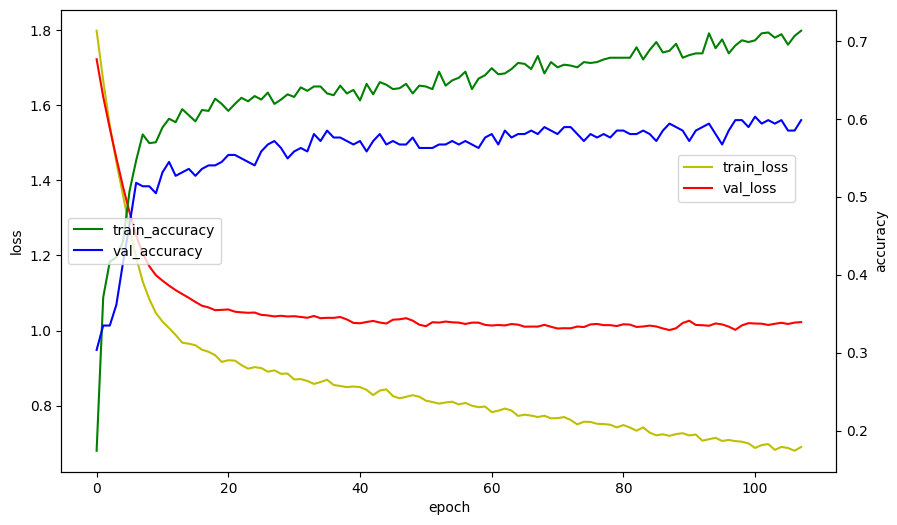

In [34]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center left')
plt.show()

In [38]:
# 모델 평가
loss_and_acc = model.evaluate(X_test, Y_test, batch_size = 100, verbose = 0)

print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')


loss:0.9688, accuracy:0.6333


In [45]:
model2 = load_model('model/wine-088-loss1.0014-acc0.5938.h5')
loss_and_acc1 = model2.evaluate(X_test, Y_test, batch_size = 100, verbose = 0)

print(f'loss:{loss_and_acc1[0]:.4f}, accuracy:{loss_and_acc1[1]:.4f}')

loss:0.9611, accuracy:0.6229


In [46]:
model.save('model/wine.h5')

In [54]:
# 교차표 (실제값과 예측값)
real = Y_test.argmax(axis=1) + 3 # 실제값
# real = np.argmax(Y_test, axis=1)
pred = model.predict(X_test).argmax(axis=1) + 3


pd.crosstab(real, pred, rownames=['real'], colnames=['predict'])

15/15 [==============================] - 0s 1ms/step


predict,3,4,5,6,7
real,,,,,
3,0,0,2,1,0
4,1,0,9,5,1
5,0,1,142,57,4
6,0,0,44,133,15
7,0,0,3,28,29
8,0,0,0,3,2


# 6. 모델 저장

In [55]:
redwine.loc[0:1]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5


In [57]:
input_data = [7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]

In [60]:
scaled_data = scaler.transform([input_data])

In [62]:
model.predict(scaled_data).argmax(axis=1) + 3

1/1 [==============================] - 0s 47ms/step


array([5], dtype=int64)